leave-k-out
Error Esperado: 0.30000000000000004
Promedio: 0.7
Desviación Estándar: 0.05962847939999442
leave-one-out
Error Esperado: 0.26
Promedio: 0.74
Desviación Estándar: 0.43863424398922624
Predicciones y Especies Reales:
1: Predicción=Virginica, Especie real=Versicolor
2: Predicción=Setosa, Especie real=Setosa
3: Predicción=Setosa, Especie real=Setosa
4: Predicción=Setosa, Especie real=Setosa
5: Predicción=Setosa, Especie real=Setosa
6: Predicción=Virginica, Especie real=Versicolor
7: Predicción=Virginica, Especie real=Virginica
8: Predicción=Virginica, Especie real=Versicolor
9: Predicción=Setosa, Especie real=Setosa
10: Predicción=Setosa, Especie real=Setosa
11: Predicción=Setosa, Especie real=Setosa
12: Predicción=Virginica, Especie real=Versicolor
13: Predicción=Virginica, Especie real=Versicolor
14: Predicción=Virginica, Especie real=Virginica
15: Predicción=Virginica, Especie real=Virginica
16: Predicción=Virginica, Especie real=Versicolor
17: Predicción=Virginica, Especie r

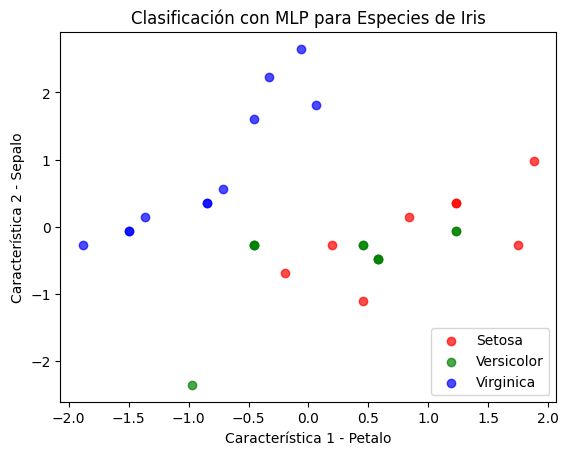

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

class MultiLayerPerceptron:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
        self.biases = [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []

        for i in range(len(self.layers) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            a = self.softmax(z) if i == len(self.layers) - 2 else self.sigmoid(z)
            self.z_values.append(z)
            self.activations.append(a)

    def backward(self, X, y, learning_rate):
        errors = [y - self.activations[-1]]
        deltas = [errors[-1]]

        for i in range(len(self.layers) - 2, 0, -1):
            error = deltas[-1].dot(self.weights[i].T)
            delta = error * self.sigmoid_derivative(self.activations[i])
            errors.append(error)
            deltas.append(delta)

        for i in range(len(self.layers) - 2, -1, -1):
            self.weights[i] += np.dot(self.activations[i].T, deltas[len(self.layers) - 2 - i]) * learning_rate
            self.biases[i] += np.sum(deltas[len(self.layers) - 2 - i], axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate):
        for _ in range(epochs):
            self.forward(X)
            self.backward(X, y, learning_rate)

    def predict(self, X):
        self.forward(X)
        return self.activations[-1]

    def evaluate_loo(self, X, y):
        loo = LeaveOneOut()
        accuracies = []

        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.train(X_train, y_train, epochs=1000, learning_rate=0.2)
            y_pred_onehot = self.predict(X_test)
            y_pred = np.argmax(y_pred_onehot, axis=1)
            y_true = np.argmax(y_test, axis=1)
            accuracies.append(accuracy_score(y_true, y_pred))
        return np.mean(accuracies), np.std(accuracies)

    def evaluate_lko(self, X, y, k):
        lko = KFold(n_splits=k)
        accuracies = []

        for train_index, test_index in lko.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.train(X_train, y_train, epochs=1000, learning_rate=0.2)
            y_pred_onehot = self.predict(X_test)
            y_pred = np.argmax(y_pred_onehot, axis=1)
            y_true = np.argmax(y_test, axis=1)
            accuracies.append(accuracy_score(y_true, y_pred))
        return np.mean(accuracies), np.std(accuracies)

data = pd.read_csv('irisbin.csv', header=None)
X = data.iloc[:, :-3].values
y = data.iloc[:, -3:].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
layers = [X.shape[1], 8, 3]
mlp = MultiLayerPerceptron(layers)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlp.train(X_train, y_train, epochs=1000, learning_rate=0.2)
predictions = mlp.predict(X_test)
lko_avg_accuracy, lko_std_deviation = mlp.evaluate_lko(X, y, k=5)
loo_avg_accuracy, loo_std_deviation = mlp.evaluate_loo(X, y)
lko_error = 1 - lko_avg_accuracy
loo_error = 1 - loo_avg_accuracy

print("leave-k-out")
print("Error Esperado:", lko_error)
print("Promedio:", lko_avg_accuracy)
print("Desviación Estándar:", lko_std_deviation)
print("leave-one-out")
print("Error Esperado:", loo_error)
print("Promedio:", loo_avg_accuracy)
print("Desviación Estándar:", loo_std_deviation)

print("Predicciones y Especies Reales:")
for i, (prediction, true_species) in enumerate(zip(predictions, y_test)):
    species_pred = ['Virginica', 'Versicolor', 'Setosa'][np.argmax(prediction)]
    species_real = ['Virginica', 'Versicolor', 'Setosa'][np.argmax(true_species)]
    print(f"{i+1}: Predicción={species_pred}, Especie real={species_real}")

plt.scatter(X_test[y_test[:, 0] == 1, 0], X_test[y_test[:, 0] == 1, 1], color='red', label='Setosa', alpha=0.7)
plt.scatter(X_test[y_test[:, 1] == 1, 0], X_test[y_test[:, 1] == 1, 1], color='green', label='Versicolor', alpha=0.7)
plt.scatter(X_test[y_test[:, 2] == 1, 0], X_test[y_test[:, 2] == 1, 1], color='blue', label='Virginica', alpha=0.7)
plt.xlabel('Característica 1 - Petalo')
plt.ylabel('Característica 2 - Sepalo')
plt.title('Clasificación con MLP para Especies de Iris')
plt.legend(loc='lower right', bbox_transform=plt.gcf().transFigure)
plt.show()
